# Task 1: Exploratory Data Analysis (EDA) and Business Insights

In [5]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')
customers = pd.read_csv('Customers.csv')

# Display the first few rows of each dataset
transactions_head = transactions.head()
products_head = products.head()
customers_head = customers.head()

# Get basic info about each dataset
transactions_info = transactions.info()
products_info = products.info()
customers_info = customers.info()

transactions_head, products_head, customers_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
<class 'pan

(  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  ,
   ProductID              ProductName     Category   Price
 0      P001     ActiveWear Biography        Books  169.30
 1      P002    ActiveWear Smartwatch  Electronics  346.30
 2      P003  ComfortLiving Biography        Books   44.12
 3      P004            BookWorld Rug   Home Decor   95.69
 4      P005          TechPro T-Shirt     Clothing  429.31,
   CustomerID        CustomerName         Region  SignupDate

In [6]:
# Convert TransactionDate and SignupDate to datetime format for analysis
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])

# Summary statistics for Transactions
transactions.describe()

,TransactionDate,Quantity,TotalValue,Price
count,1000,1000.000000,1000.000000,1000.00000
mean,2024-06-23 15:33:02.768999936,2.537000,689.995560,272.55407
min,2023-12-30 15:29:12,1.000000,16.080000,16.08000
25%,2024-03-25 22:05:34.500000,2.000000,295.295000,147.95000
50%,2024-06-26 17:21:52.500000,3.000000,588.880000,299.93000
75%,2024-09-19 14:19:57,4.000000,1011.660000,404.40000
max,2024-12-28 11:00:00,4.000000,1991.040000,497.76000
std,NaN,1.117981,493.144478,140.73639


### Product Categories Distribution

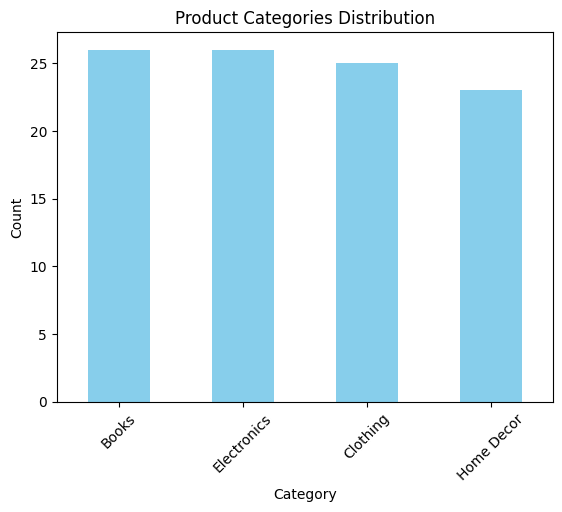

In [7]:

# Count of products per category
products_per_category = products['Category'].value_counts()

# Plot Product Categories
products_per_category.plot(kind='bar', color='skyblue', title='Product Categories Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Transactions per Region

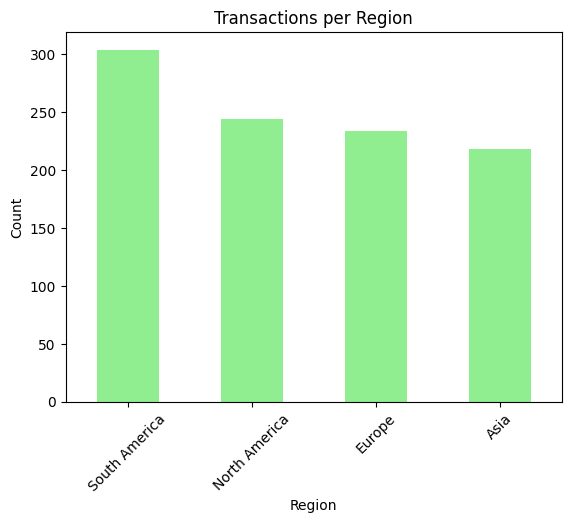

In [8]:

# Transactions per region
transactions_with_customers = transactions.merge(customers, on='CustomerID')
transactions_per_region = transactions_with_customers['Region'].value_counts()

# Plot Transactions per Region
transactions_per_region.plot(kind='bar', color='lightgreen', title='Transactions per Region')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Monthly Sales Trend

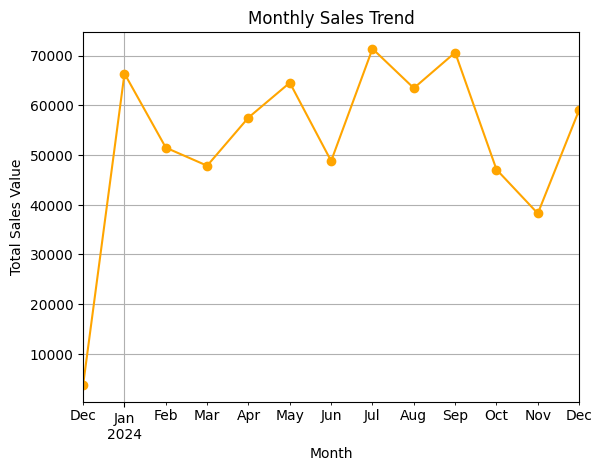

In [9]:

# Monthly sales trend
transactions['Month'] = transactions['TransactionDate'].dt.to_period('M')
monthly_sales = transactions.groupby('Month')['TotalValue'].sum()

# Plot Monthly Sales
monthly_sales.plot(color='orange', marker='o', title='Monthly Sales Trend')
plt.ylabel('Total Sales Value')
plt.xlabel('Month')
plt.grid(True)
plt.show()


In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Merge transactions with products and customers
transactions_products = transactions.merge(products, on="ProductID")
full_data = transactions_products.merge(customers, on="CustomerID")

# Feature engineering: Aggregate data for customer profiles
customer_profiles = full_data.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),
    TransactionCount=('TransactionID', 'count'),
    AvgTransactionValue=('TotalValue', 'mean'),
    CategoryBooks=('Category', lambda x: (x == 'Books').sum()),
    CategoryElectronics=('Category', lambda x: (x == 'Electronics').sum()),
    CategoryClothing=('Category', lambda x: (x == 'Clothing').sum()),
    CategoryHomeDecor=('Category', lambda x: (x == 'Home Decor').sum())
).reset_index()

# Normalize numerical features for similarity computation
features = ['TotalSpending', 'TransactionCount', 'AvgTransactionValue',
            'CategoryBooks', 'CategoryElectronics', 'CategoryClothing', 'CategoryHomeDecor']
customer_profiles_normalized = customer_profiles.copy()
customer_profiles_normalized[features] = (
    customer_profiles[features] - customer_profiles[features].mean()
) / customer_profiles[features].std()

# Compute similarity scores using cosine similarity
customer_vectors = customer_profiles_normalized[features].values
similarity_matrix = cosine_similarity(customer_vectors)

# Extract top 3 similar customers for the first 20 customers
lookalikes = {}
for i, cust_id in enumerate(customer_profiles['CustomerID'][:20]):
    similarities = list(enumerate(similarity_matrix[i]))
    top_similar = sorted(similarities, key=lambda x: x[1], reverse=True)[1:4]
    lookalikes[cust_id] = [(customer_profiles['CustomerID'][j], round(score, 4)) for j, score in top_similar]

# Convert to DataFrame for export
lookalike_df = pd.DataFrame({
    'CustomerID': lookalikes.keys(),
    'Lookalikes': [str(v) for v in lookalikes.values()]
})

# Save the lookalike data to CSV
lookalike_df.to_csv('Lookalike.csv', index=False)

lookalike_csv_path


'/mnt/data/Lookalike.csv'